## [Градиентный бустинг над решающими деревьями](https://www.coursera.org/learn/vvedenie-mashinnoe-obuchenie/programming/uDU31/gradiientnyi-bustingh-nad-rieshaiushchimi-dieriev-iami)

## Введение
Построение композиции — важный подход в машинном обучении, который позволяет объединять большое количество слабых алгоритмов в один сильный. Данный подход широко используется на практике в самых разных задачах.

На лекциях был рассмотрен метод градиентного бустинга, который последовательно строит композицию алгоритмов, причем каждый следующий алгоритм выбирается так, чтобы исправлять ошибки уже имеющейся композиции. Обычно в качестве базовых алгоритмов используют деревья небольшой глубины, поскольку их достаточно легко строить, и при этом они дают нелинейные разделяющие поверхности.

Другой метод построения композиций — случайный лес. В нем, в отличие от градиентного бустинга, отдельные деревья строятся независимо и без каких-либо ограничений на глубину — дерево наращивается до тех пор, пока не покажет наилучшее качество на обучающей выборке.

В этом задании мы будем иметь дело с задачей классификации. В качестве функции потерь будем использовать log-loss:  
### $L(y,z)=-y\log{z}-(1-y)\log(1-z)$  
Здесь через $y$ обозначен истинный ответ, через $z$ — прогноз алгоритма. Данная функция является дифференцируемой, и поэтому подходит для использования в градиентном бустинге. Также можно показать, что при ее использовании итоговый алгоритм будет приближать истинные вероятности классов.

---

## Реализация в sklearn

В пакете scikit-learn градиентный бустинг реализован в модуле ensemble в виде классов GradientBoostingClassifier и GradientBoostingRegressor. Основные параметры, которые будут интересовать нас: n_estimators, learning_rate. Иногда может быть полезен параметр verbose для отслеживания процесса обучения.

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from collections import ChainMap
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from math import exp
from sklearn.ensemble import RandomForestClassifier

## 1. Загрузите выборку из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив numpy (параметр values у датафрейма). 
В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и random_state = 241. 

In [2]:
data = pd.read_csv('./data/gbm-data.csv')
X = data.loc[:, 'D1':].values
y = data['Activity'].values
print(len(data))
data.head()

3751


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)
len(X_test)

3001

## 2. Обучите GradientBoostingClassifier с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:

* Используйте метод staged_decision_function для предсказания качества на обучающей и тестовой выборке на каждой итерации.
* Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле $1 / (1 + e^{−y})$, где $y$ — предсказанное значение.
* Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции sklearn.metrics.log_loss) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.

## 3. Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? 
В ответе укажите одно из слов overfitting либо underfitting.

In [4]:
[1 / (1 + exp(-y)) for y in np.arange(0.1, 2.0, .1)] 

[0.52497918747894,
 0.549833997312478,
 0.574442516811659,
 0.598687660112452,
 0.6224593312018546,
 0.6456563062257954,
 0.6681877721681662,
 0.6899744811276125,
 0.7109495026250039,
 0.7310585786300049,
 0.7502601055951177,
 0.7685247834990178,
 0.7858349830425586,
 0.8021838885585818,
 0.8175744761936437,
 0.8320183851339245,
 0.8455347349164652,
 0.8581489350995123,
 0.8698915256370021]

In [5]:
log_loss([0, 1], [1, 0])

34.53917619362578

In [6]:
log_loss([1, 0], [1, 0])

9.992007221626415e-16

In [7]:
eviance = np.zeros((10,), dtype=np.float64)
for i in range(10):
    eviance[i] = i
eviance
eviance[::2]

array([0., 2., 4., 6., 8.])

      Iter       Train Loss   Remaining Time 
         1           1.0190           14.90s
         2           0.9192           14.75s
         3           0.8272           13.94s
         4           0.7834           13.29s
         5           0.7109           13.09s
         6           0.6368           13.25s
         7           0.5797           13.13s
         8           0.5610           12.77s
         9           0.5185           12.63s
        10           0.4984           12.39s
        20           0.1999           11.78s
        30           0.1313           10.93s
        40           0.0790           10.39s
        50           0.0511            9.87s
        60           0.0352            9.37s
        70           0.0245            8.82s
        80           0.0162            8.33s
        90           0.0114            7.82s
       100           0.0077            7.33s
       200           0.0004            2.19s
      Iter       Train Loss   Remaining Time 
        

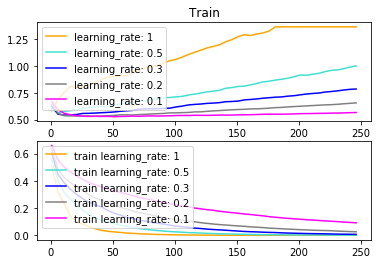

In [8]:
grid = [1, 0.5, 0.3, 0.2, 0.1]
params = dict(n_estimators=250, verbose=True, random_state=241, learning_rate=None)

f, ax = plt.subplots(nrows=2, ncols=1)
plt.rcParams['figure.figsize'] = (27.0, 9.0)

all_result_sigm = [None] * len(grid)

for j, color, learning_rate in zip(range(len(grid)), ['orange', 'turquoise', 'blue', 'gray', 'magenta'], [1, 0.5, 0.3, 0.2, 0.1]) :
    
    label = f"learning_rate: {learning_rate}"
    
    params['learning_rate'] = learning_rate
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    
    # compute test set deviance
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = log_loss(y_test, [1 / (1 + exp(-y)) for y in y_pred])
    
    all_result_sigm[j] = test_deviance
    ax[0].plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
               '-', color=color, label=label)
    
    train_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_train)):
        train_deviance[i] = log_loss(y_train, [1 / (1 + exp(-y)) for y in y_pred])
    
    ax[1].plot((np.arange(train_deviance.shape[0]) + 1)[::5], train_deviance[::5],
               '-', color=color, label=f"train learning_rate: {learning_rate}")


ax[0].legend(loc='upper left')
ax[0].set_title(f"Test")
ax[1].legend(loc='upper left')
ax[0].set_title(f"Train")

plt.show()

## 4. Приведите минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.

In [9]:
np.argmin(all_result_sigm[3])

36

In [10]:
round(all_result_sigm[3][36], 2)

0.53

## 5. На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. 
Какое значение log-loss на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. В данном случае брать сигмоиду от оценки вероятности класса не нужно).

In [14]:
clf = RandomForestClassifier(n_estimators=36, random_state=241)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=36, n_jobs=None,
            oob_score=False, random_state=241, verbose=0, warm_start=False)

In [21]:
y_pred = clf.predict_proba(X_test)
round(log_loss(y_test, y_pred), 2)

0.54